<a href="https://colab.research.google.com/github/Neha-kumari31/DS-Unit-2-Regression-Classification/blob/master/assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [X] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [X] Engineer at least two new features. (See below for explanation & ideas.)
- [X] Fit a linear regression model with at least two features.
- [X] Get the model's coefficients and intercept.
- [X] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [X] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [X] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [X] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [X] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [X] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.
- [ ] Add your own stretch goal(s) !

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module2')

     |████████████████████████████████| 133kB 9.3MB/s 
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
     |████████████████████████████████| 614kB 34.2MB/s 
     |████████████████████████████████| 225kB 49.8MB/s 
     |████████████████████████████████| 768kB 36.6MB/s 
     |████████████████████████████████| 194kB 54.7MB/s 
     |████████████████████████████████| 51kB 23.9MB/s 
     |████████████████████████████████| 51kB 23.1MB/s 
     |████████████████████████████████| 737kB 50.9MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=c008d155cab530ebaeeef883fbdc3761832bafe33f74a720ebcd0aedbd1e7e2f
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=23fa9e8e7cbc506f87d5345d512a75e5eb00f3ca3ecb70346fca43a6cf0a085c
  Stored in directory: /root/.

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Use these functions later

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Note, `description` has missing values.

## Feature Engineering

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

##Check the Ols assumption
1) linearity- draw the scatter plot of each feature vs target , ifnot than do the log transformation(logprice= np.log(df['price'])

2) No endogeneity- No independent variable should be correlated

3) Normality(large sample data), zero mean, homocadacity

4) No autocorrelation(change in one target value with the change of other )

5)multicolinearity- when two independent variables agr highly correlated(check using stas model VIF)

###scale the variable

### Combine `dogs_allowed` and/or `cats_allowed` into `pets_allowed` since they are redundant features with high correlation.

In [0]:
# Combine them into a new feature pets_allowed
df['cats_and_dogs_allowed'] = (df['dogs_allowed'] & df['cats_allowed'])
df['cats_or_dogs_allowed'] = (df['dogs_allowed'] | df['cats_allowed'])
# Drop cats and dogs allowed
df = df.drop(['dogs_allowed', 'cats_allowed'], axis=1)
df['cats_or_dogs_allowed'].value_counts()

0    25433
1    23384
Name: cats_or_dogs_allowed, dtype: int64

In [0]:
df['cats_and_dogs_allowed'].value_counts()

0    27001
1    21816
Name: cats_and_dogs_allowed, dtype: int64

In [0]:
# Let's verify the columns were dropped and new feature was added
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,hardwood_floors,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,cats_and_dogs_allowed,cats_or_dogs_allowed
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Label encode categorical `interest_level` data type

*   List item
*   List item



In [0]:
# Let's look at the counts first before we encode it
df['interest_level'].value_counts()

low       33946
medium    11181
high       3690
Name: interest_level, dtype: int64

In [0]:
df['interest_level'] = df['interest_level'].map({'low':1, 'medium':2, 'high':3})
df['interest_level'].value_counts() # Verify the counts are right

1    33946
2    11181
3     3690
Name: interest_level, dtype: int64

### `total_rooms`

In [0]:
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['total_rooms'].value_counts()

2.0     15286
3.0     11083
1.0      9200
4.0      6940
5.0      3160
6.0      1605
4.5       291
7.0       277
3.5       210
5.5       190
2.5       154
0.0       151
8.0        83
6.5        67
9.0        49
7.5        32
10.0       16
8.5        11
1.5         9
12.0        2
11.0        1
Name: total_rooms, dtype: int64

### `total_perks`

This will help visualize, how to sum the perks of the columns

![](https://i.stack.imgur.com/gj5ue.jpg)

In [0]:
perks = [col for col in df.columns if col not in ['price', 'bathrooms', 'bedrooms', 'latitude', 'longitude', 'display_address', 'created', 'description', 'cats_or_dogs_allowed']]
df['total_perks'] = df[perks].sum(axis=1)
df['total_perks'].value_counts() # Value counts will help us understand the perks better

6.0     6290
5.0     5895
7.0     5390
8.0     4529
4.0     4296
9.0     3793
10.0    3027
11.0    2576
12.0    2142
3.0     2133
13.0    1856
14.0    1459
15.0    1265
16.0     904
17.0     643
18.0     460
2.0      449
19.0     332
20.0     160
21.0     118
8.5       90
9.5       89
10.5      87
11.5      85
7.5       83
6.5       82
12.5      69
13.5      64
22.0      59
5.5       56
14.5      50
1.0       45
4.5       41
16.5      39
15.5      37
18.5      22
17.5      20
23.0      16
19.5      14
3.5       11
24.0      10
20.5      10
21.5       9
22.5       3
25.0       3
26.0       3
24.5       2
2.5        1
Name: total_perks, dtype: int64

In [0]:
df['total_perks'] = df[perks].sum(axis=1)
df['total_perks'].value_counts() # Value counts will help us understand the perks better

6.0     6290
5.0     5895
7.0     5390
8.0     4529
4.0     4296
9.0     3793
10.0    3027
11.0    2576
12.0    2142
3.0     2133
13.0    1856
14.0    1459
15.0    1265
16.0     904
17.0     643
18.0     460
2.0      449
19.0     332
20.0     160
21.0     118
8.5       90
9.5       89
10.5      87
11.5      85
7.5       83
6.5       82
12.5      69
13.5      64
22.0      59
5.5       56
14.5      50
1.0       45
4.5       41
16.5      39
15.5      37
18.5      22
17.5      20
23.0      16
19.5      14
3.5       11
24.0      10
20.5      10
21.5       9
22.5       3
25.0       3
26.0       3
24.5       2
2.5        1
Name: total_perks, dtype: int64

It looks like, most of the apartment listings have between 4-10 perks.

### `has_description`

In [0]:
df['has_description'] = df['description'].isna().astype(int)
df['has_description'].value_counts()

0    47392
1     1425
Name: has_description, dtype: int64

### `description_size`

In [0]:
df['description'] = df['description'].fillna('')
df['description_size'] = df['description'].apply(lambda x: len(x))
df['description_size'].value_counts()

8       1627
0       1425
24       327
1        236
105      131
572       85
535       84
390       83
605       83
477       83
356       83
569       82
378       81
514       78
424       78
589       78
498       77
529       77
590       76
635       75
548       75
507       74
436       74
151       73
525       73
626       73
570       73
319       72
603       72
599       72
        ... 
2423       1
2231       1
1719       1
2135       1
2222       1
1973       1
2830       1
1877       1
1845       1
1679       1
1870       1
1838       1
1806       1
1814       1
1687       1
2639       1
1606       1
1559       1
1614       1
3367       1
2422       1
2294       1
1710       1
2166       1
2070       1
2006       1
1742       1
1878       1
3010       1
2248       1
Name: description_size, Length: 2080, dtype: int64

### `beds/bath` ratio

In [0]:
df['beds_bath_ratio'] = (df['bedrooms'] / df['bathrooms']).replace([np.inf, -np.inf], np.nan).fillna(0)
df['beds_bath_ratio'].describe()

count    48817.000000
mean         1.262440
std          0.877438
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: beds_bath_ratio, dtype: float64

## Correlations

In [0]:
def correlations(data, y, xs):
    from scipy import stats
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

imp_features = [col for col in df.columns if col not in ['price', 'display_address', 'created', 'description', 'street_address', 'interest_level']]
correlations(df, 'price', imp_features)

,feature,r,rho
0,bathrooms,0.687296,0.552527
1,bedrooms,0.535503,0.570723
2,latitude,-0.036286,-0.112774
3,longitude,-0.251004,-0.352461
4,elevator,0.207169,0.264353
5,hardwood_floors,0.101503,0.128908
6,doorman,0.276215,0.342583
7,dishwasher,0.223899,0.283984
8,no_fee,0.132240,0.182481
9,laundry_in_building,-0.019417,-0.003954


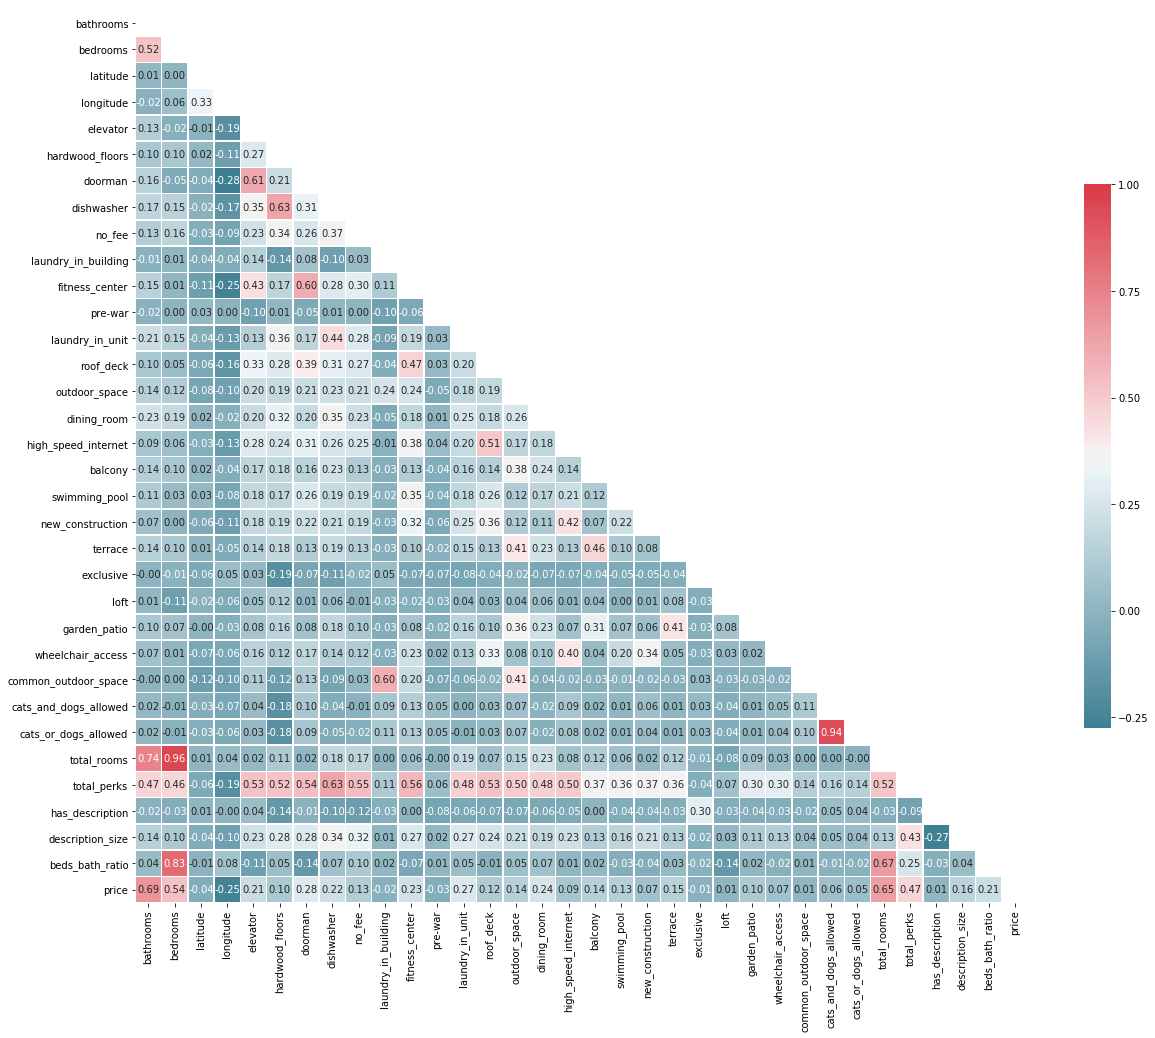

In [0]:
def correlation_heatmap(data=None, vmax=1, annot=True, corr_type='pearson', figsize=(12, 12)):
    if data is None:
        raise ValueError(
            "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    # Taken from the seaborn example at:
    # http://seaborn.pydata.org/examples/many_pairwise_correlations.html
    # Compute the correlation matrix
    corr = data.corr(corr_type)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    fig, axes = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=vmax, annot=annot, square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, fmt=',.2f', ax=axes)
    plt.show()
    plt.close()
corr_features = imp_features
corr_features.append('price')
correlation_heatmap(df[corr_features], figsize=(20, 20))

# Linear Regression Model

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [0]:
def linear_model_results(data, features, target, by_date=True, seed=12345):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    results = {}
    results['n'] = data.shape

    # Import to split the data into training/testing sets
    from sklearn.model_selection import train_test_split
    # Import Linear Model
    from sklearn.linear_model import LinearRegression
    # Import metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    # Extract features 
    if by_date:
        train = df[df['created'].dt.month.isin([4, 5])]
        test = df[~df['created'].dt.month.isin([4, 5])]
        X_train = train[features]
        y_train = train[target]
        X_test = test[features]
        y_test = test[target]
    else:
        # Train-Test Split
        X = df[features]
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
    
    # Instantiate Linear Regression Mode
    model = LinearRegression().fit(X_train, y_train)
    # Add model to results
    results['model'] = model
    # Add coefficients to results
    results['coefficients'] = model.coef_[0]

    # Calculate metrics on training data
    # Add R^2 
    results['train_r_squared'] = model.score(X_train, y_train)
    # Predict
    y_train_hat = model.predict(X_train)
    # MSE
    results['train_MSE'] = mean_squared_error(y_train, y_train_hat)
    # RMSE
    results['train_RMSE'] = np.sqrt(results['train_MSE'])
    # MAE
    results['train_MAE'] = mean_absolute_error(y_train, y_train_hat)

    # Calculate metrics on the test data
    # Add R^2 
    results['test_r_squared'] = model.score(X_test, y_test)
    # Predict
    y_test_hat = model.predict(X_test)
    # MSE
    results['test_MSE'] = mean_squared_error(y_test, y_test_hat)
    # RMSE
    results['test_RMSE'] = np.sqrt(results['test_MSE'])
    # MAE
    results['test_MAE'] = mean_absolute_error(y_test, y_test_hat)
    return results

### Baseline Model

Let's look at the baseline model, first

In [0]:
df['price'].describe()

count    48817.000000
mean      3579.585247
std       1762.430772
min       1375.000000
25%       2500.000000
50%       3150.000000
75%       4095.000000
max      15500.000000
Name: price, dtype: float64

### All the features

In [0]:
# 1. Extract features and target
target = 'price'
omit_features = ['display_address', 'created', 'description', 'street_address', 'interest_level']
omit_features.append(target)
features = [col for col in df.columns.tolist() if col not in omit_features]

# 2. Instantiate Linear Regression Model
results = linear_model_results(df, features, target)

print("""
----------- Linear Regression Model Results -------------
Training Set
R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
MSE: {:.2f}
RMSE: {:.2f}
MAE: ${:.2f}

Test Set
R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
MSE: {:.2f}
RMSE: {:.2f}
MAE: ${:.2f}
""".format(results['train_r_squared'], results['train_MSE'], results['train_RMSE'], results['train_MAE'], results['test_r_squared'], results['test_MSE'], results['test_RMSE'], results['test_MAE']))


----------- Linear Regression Model Results -------------
Training Set
R^2: 0.64 (Explained variance score: 1 is perfect prediction)
MSE: 1127011.26
RMSE: 1061.61
MAE: $673.28

Test Set
R^2: 0.65 (Explained variance score: 1 is perfect prediction)
MSE: 1096682.78
RMSE: 1047.23
MAE: $676.74



## Again Feature Engineering

Now let's assign those listings their neighboorhods.

In [0]:
df['latitude'].describe()

count    48817.000000
mean        40.750760
std          0.038954
min         40.575700
25%         40.728300
50%         40.751700
75%         40.774000
max         40.989400
Name: latitude, dtype: float64

In [0]:
df['longitude'].describe()

count    48817.000000
mean       -73.972760
std          0.028883
min        -74.087300
25%        -73.991800
50%        -73.978000
75%        -73.955000
max        -73.700100
Name: longitude, dtype: float64

### Rental listing maps plotted with price as marker size indicator

In [0]:
!ls -lah

total 36K
drwxr-xr-x 2 root root 4.0K Sep 15 19:21 .
drwxr-xr-x 1 root root 4.0K Sep 15 19:21 ..
-rw-r--r-- 1 root root 6.0K Sep 15 19:21 assignment_regression_classification_2.ipynb
-rw-r--r-- 1 root root  20K Sep 15 19:21 lesson_regression_classification_2.ipynb
-rw-r--r-- 1 root root    0 Sep 15 19:21 README.md


In [0]:
mapbox_token = open(".mapbox_token").read()
px.set_mapbox_access_token(mapbox_token)
px.scatter_mapbox(df, lat='latitude', lon='longitude', color='price', zoom=11, size='price', hover_data=['bedrooms', 'bathrooms'])

FileNotFoundError: ignored

So, NY has 5 boroughs,

![](https://i.imgur.com/RmAqNSV.png)

## K-Means Clustering

### Using Elbow method figure out the best clusters

In [0]:
def k_means_results(data, k, seed):
    from sklearn.cluster import KMeans
    # Initialize and predict k-means clusters
    results = {}
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kcl = kmeans.fit(data)
    # Add results from model
    results['data'] = data
    results['k'] = k
    results['labels'] = kcl.labels_
    results['SSE'] = kcl.inertia_
    return results

In [0]:
k_means_features = ['latitude', 'longitude']
ks = np.arange(1, 21)
sses = []
seed = 1234
for k in ks:
    result = k_means_results(df[k_means_features], k, seed)
    sses.append(result['SSE'])
kmeans_results = pd.DataFrame.from_records(zip(ks, sses), columns=['K', 'SSE'])
kmeans_results

In [0]:
def elbow_plot(ks, sses):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(ks, sses, color='firebrick', label='SSE')
    ax.set_title("Elbow plot of features")
    ax.set_xticks(ks)
    ax.set_xticklabels(ks)
    ax.set_xlabel("K")
    ax.set_ylabel("SSE")
    ax.tick_params(bottom=True, top=False, left=False, right=False)
    # Hide all of the spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Turn off y axis grid
    ax.grid(axis='x')
    plt.show()
elbow_plot(kmeans_results.K, kmeans_results.SSE)

Elbow plot doesn't show us any definite `k` values, based on what we know of NYC boroughs, we can pick 5 as our `k`. Let's see if that improves model performance or not.

### Choosing the best k

In [0]:
# Clustering the locations based on k
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, n_jobs=-1)
df['cluster'] = kmeans.fit_predict(df[k_means_features])
px.scatter_mapbox(df, lat='latitude', lon='longitude', color='cluster', zoom=11, size='price', hover_data=['bedrooms', 'bathrooms'], title="Apartment Rental listings grouped by clusters")

In [0]:
px.scatter(df, x='latitude', y='longitude', color='cluster', title="Apartment Rental listings grouped by clusters")

In [0]:
# 1. Extract features and target
target = 'price'
omit_features = ['price', 'display_address', 'created', 'description', 'street_address', 'interest_level']
features = [col for col in df.columns.tolist() if col not in omit_features]

# 2. Apply linear model and store results dict
results = linear_model_results(df, features, target)

# 3. Pretty Prinat the results out
print("""
----------- Linear Regression Model Results -------------
Training Set
R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
MSE: {:.2f}
RMSE: {:.2f}
MAE: ${:.2f}

Test Set
R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
MSE: {:.2f}
RMSE: {:.2f}
MAE: ${:.2f}
""".format(results['train_r_squared'], results['train_MSE'], results['train_RMSE'], results['train_MAE'], results['test_r_squared'], results['test_MSE'], results['test_RMSE'], results['test_MAE']))

It doesn't look like add new feature `clusters` made any improvement in models's ability to explain variance in our data.